<h2><center> Capstone Project 1: Inferential Statistics</center></h2>

In this section, I present an analysis of data using inferntial statistics. I will test the statistical significance of various observations raised in <b>[Data Story](https://github.com/lekhnath12/Traffic_violation_Montgomery/blob/gh-pages/Data_Story.ipynb)</b> section. For all statistical analysis, we set level of signifiance to be 1%. 

In [1]:
#import necessary modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from IPython.core.display import Image, display
from IPython.core.display import HTML

In [2]:
# Read the accident data from csv
df_traffic = pd.read_csv('Traffic_Violations-api.csv', 
                           parse_dates = [['Date Of Stop', 'Time Of Stop']],
                           infer_datetime_format = True)

<b>More violation takes place in spring (Mar - May) compared to summer (June - Aug).</b>

To test this hypothesis, first assume a null hypothesis that the number of violations are equal. We find that the the p-value is 0.0, which confirms that more violations takes place in spring compared to summer. 

In [3]:
# Create datetime column and series containing month information
df_traffic['datetime'] = df_traffic['Date Of Stop_Time Of Stop']
month = df_traffic.datetime.dt.month

# Find the spring and summer subset and replace the data by 1 or 0
springbool = (month>=3) & (month <= 5)
summerbool = (month>=6) & (month <= 8)

spring = month.where(springbool, 0)
spring = spring.where(~springbool, 1)

summer = month.where(summerbool, 0)
summer = summer.where(~summerbool, 1)

t_value, p_value = st.ttest_ind_from_stats(mean1 = spring.mean(), std1 = spring.std(), nobs1 = spring.count(),
                                           mean2 = summer.mean(), std2 = summer.std(), nobs2 = summer.count())

print('Total # of Violations in spring', spring.mean()*spring.count())
print('Total # of Violations in summer', summer.mean()*summer.count())

print('p-value: ', p_value)


Total # of Violations in spring 391090.0
Total # of Violations in summer 354074.0
p-value:  0.0


<b>More violations occur in late night (after 10 pm) rather than the busy traffic hours. </b>

We set a null hypothesis that equal number of violations occur during busy hours and late night. The p-value of our statistical test is zero, which rejectes our null hypothesis. 

In [4]:
# Create datetime column and series containing month information
hour = df_traffic.datetime.dt.hour

latenightbool = (hour>=22) & (hour <= 24)
busyhourbool =  (hour>=7) & (hour < 9)

latenight = hour.where(latenightbool, 0)
latenight = latenight.where(~latenightbool, 1)

busyhour = hour.where(busyhourbool, 0)
busyhour = busyhour.where(~busyhourbool, 1)

t_value, p_value = st.ttest_ind_from_stats(mean1 = latenight.mean(), std1 = latenight.std(), nobs1 = latenight.count(),
                                           mean2 = busyhour.mean(), std2 = busyhour.std(), nobs2 = busyhour.count())

print('Total # of Violations in busy hours', busyhour.mean()*busyhour.count())
print('Total # of Violations in late nights', latenight.mean()*latenight.count())

print('p-value: ', p_value)

Total # of Violations in busy hours 122611.0
Total # of Violations in late nights 213159.0
p-value:  0.0


<b>The citation probability is higher in the weekends rather than a busy weekday.</b>

Null hypothesis: <i> The citation probability of all days are equal</i>

The test below gives p-value of 0.012, which is greater than 1% level of significance. Hence we can not reject the null hypothesis. In other words, our statement that the citation probability depends on days of week is not statistically reliable. 

Regression: 0.8670562212834654
p-value: 0.011507235471835691


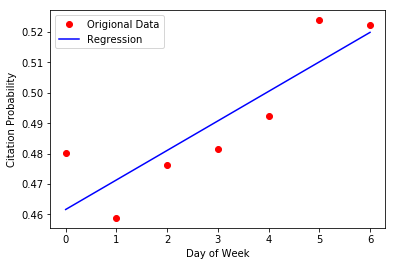

In [5]:
df_traffic['day'] = df_traffic.datetime.dt.dayofweek
df = df_traffic.groupby(['day', 'Violation Type']).count()
ct_prob = list()

n = 6
ages = np.linspace(0,n, n+1)

for age in ages:
    citn = df.loc[(age, 'Citation'), 'Agency']
    other = df.loc[(age, 'Warning'), 'Agency']
    prob = citn/(citn + other)
    ct_prob.append(prob)

plt.plot(ages, ct_prob, 'ro', label = 'Origional Data')

slope, intercept, rvalue, pvalue, std_err = st.linregress(ages,ct_prob)
plt.plot(ages, intercept+slope*ages, 'b', label = 'Regression')

plt.xlabel('Day of Week')
plt.ylabel('Citation Probability')
plt.legend()
print('Regression:', rvalue)
print('p-value:', pvalue)

<b>Hispanic and Black drivers receive much more citations per warning compared to Asian and white drivers.</b>

We consider a null hypothesis that both subgroups HISPANIC/BLACK and WHITE/ASIAN have same ratio of citations to warning. To test this hypothesis, we perform a statistical test. The p-value of our statistical test is 0, hence we can not reject our null hypothesis. This confirms that Hispanic and Black drivers receive much more citations per warning compared to Asian and white drivers.

In [6]:
hisblk = df_traffic[(df_traffic.Race == 'HISPANIC') | (df_traffic.Race == 'BLACK')]\
                   ['Violation Type']
hisblk = pd.get_dummies(hisblk, drop_first = True)

asnwht = df_traffic[(df_traffic.Race == 'ASIAN') | (df_traffic.Race == 'WHITE')]\
                   ['Violation Type']
asnwht = pd.get_dummies(asnwht, drop_first = True)

data1 = hisblk.Warning
data2 = asnwht.Warning

t_value, p_value = st.ttest_ind_from_stats(mean1 = data1.mean(), std1 = data1.std(), nobs1 = data1.count(),
                                           mean2 = data2.mean(), std2 = data2.std(), nobs2 = data2.count())

print('Hispanic/Black citation probability:', (data1.count() - data1.sum())/data1.count())
print('Asian/White citation probability:', (data2.count() -data2.sum())/data2.count())

print('p-value: ', p_value)

Hispanic/Black citation probability: 0.5519977016683425
Asian/White citation probability: 0.47191079539040043
p-value:  0.0


In [7]:
# First convert into vector
df_traffic.dropna(inplace = True)
corpus = df_traffic.Description

vectorizer = CountVectorizer(stop_words = 'english', 
                             strip_accents = 'ascii', 
                             min_df = 0.0, 
                             max_features = 100,
                             token_pattern='[a-z]+',
                             max_df = 1.0,
                             binary  = True)

X = vectorizer.fit_transform(corpus)

In [8]:
# then group the dataframe by description column. This compress the size of Series by a 
#factor of 10

df = df_traffic.loc[:, ['Color', 'Description']].groupby('Description').count()
df.sort_values(by = 'Color', ascending = False, inplace = True)

df.rename(index=str, columns={"Color": "Count"}, inplace = True)
df.reset_index(inplace = True)

# change the text into vector array
X = vectorizer.transform(df.Description).toarray()

# This function calculates the similarity of each rows to all other remaining rows, and return 
# the index of dataframe df that are similar. The tuning parameter factor choice. Higher value 
# factor means gives index of columns that are more similar
def matching_text(text_vector, TEXT_ARRAY, factor = 0.7):
    x1 = np.matmul(text_vector, TEXT_ARRAY.transpose())
    x1 = x1/np.sqrt(np.sum(x1**2))
    ind = np.argwhere(x1[0]> factor*x1[0].max())
    return ind

# High speed drivers ?
df_copy = df_traffic.copy(deep = False)
text = 'EXCEEDING SPEED LIMIT'
X = vectorizer.transform(df_copy.Description).toarray()
x = vectorizer.transform([text]).toarray()

similarity = np.matmul(x, X.T)
similarity = similarity/np.sqrt(np.sum(similarity**2))
similarity =  similarity/np.max(similarity)

df_copy['speeding'] = similarity.T
df_copy.speeding = df_copy.speeding.where(df_copy.speeding < 0.66, 1)
df_copy.speeding = df_copy.speeding.where(df_copy.speeding >= 0.66, 0)

<b> White and Asian drivers generally cause speeding compared to Black and Hispanics. </b>

Our analysis tells that Asian and White drivers cause more accidents compared to Black and Hispanics, although Black and Hispanics receive more citations compared to Asian and Whites. First, we set a null hypothesis that both category receive equal proportion of citation and warnings. From our statistical analysis, we obtain a p-value of 0, hence we can reject the null hypothesis. Hence, it is statistically significant that white and Asian cause more speeding. 

In [9]:
hisblk = df_copy[(df_copy.Race == 'HISPANIC') | (df_copy.Race == 'BLACK')].speeding

asnwht = df_copy[(df_copy.Race == 'ASIAN') | (df_copy.Race == 'WHITE')].speeding

data1 = hisblk
data2 = asnwht

t_value, p_value = st.ttest_ind_from_stats(mean1 = data1.mean(), std1 = data1.std(), nobs1 = data1.count(),
                                           mean2 = data2.mean(), std2 = data2.std(), nobs2 = data2.count())

print('Fraction of speeding drivers in Hispanic/Black:', (data1.sum())/data1.count())
print('Fraction of speeding drivers in Asian/White :', (data2.sum())/data2.count())

print('p-value: ', p_value)

Fraction of speeding drivers in Hispanic/Black: 0.0985534800449958
Fraction of speeding drivers in Asian/White : 0.18301373025951742
p-value:  0.0


<b> Women are more likely to cause speeding compared to men.</b>

Similarly, we set a null hypothesis that women cause equal speeding compared to men. From the statistical test below, we obtain p-value of 0. Therefore we can <b>reject</b> the null hypothesis. 

In [10]:
women = df_copy[(df_copy.Gender == 'F')].speeding

men = df_copy[(df_copy.Gender == 'M')].speeding

data1 = women
data2 = men

t_value, p_value = st.ttest_ind_from_stats(mean1 = data1.mean(), std1 = data1.std(), nobs1 = data1.count(),
                                           mean2 = data2.mean(), std2 = data2.std(), nobs2 = data2.count())

print('Fraction of female speeding drivers:', (data1.sum())/data1.count())
print('Fraction of male speeding drivers in Asian/White :', (data2.sum())/data2.count())

print('p-value: ', p_value)

Fraction of female speeding drivers: 0.15991160664959067
Fraction of male speeding drivers in Asian/White : 0.12546944817566272
p-value:  0.0


<b> Drivers having new cars are more likely have speeding habits</b>

We perform a linear regression on age and fraction of speeding drivers. This gives a pearson correlation coefficient of -0.98, which means the Age is negatively correlated with the fraction of speeding drivers, i.e. fraction of speeding drivers decreases with increasing age of the vehicle. 

The p-value of our analysis is extremely small $10^{-16}$, therefore, we can reject the null hypothesis that there is no correlation. This shows that it is real that drivers with new cars have more likely to have speeding habits. 



Regression: -0.9849114153840799
p-value: 6.144965002600786e-16


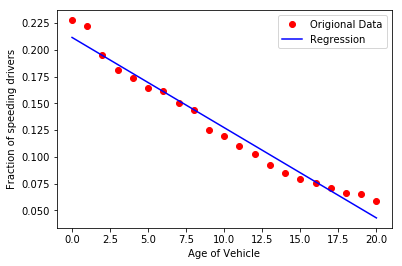

In [11]:
df_copy['datetime'] = df_copy['Date Of Stop_Time Of Stop']
df_copy['V_Age'] =  df_copy.datetime.dt.year - df_copy.Year 
real_bool = (df_copy.V_Age <= 70) & (df_copy.V_Age >= 0)
year_med = np.median(df_copy[real_bool].V_Age)

df_copy.V_Age = df_copy[['V_Age']].where(real_bool, year_med)

df = df_copy.groupby(['V_Age', 'speeding']).count()
ct_prob = list()

n = 20
ages = np.linspace(0,n, n+1)

for age in ages:
    speeding = df.loc[(age, 1), 'Agency']
    other = df.loc[(age, 0), 'Agency']
    prob = speeding/(speeding + other)
    ct_prob.append(prob)

plt.plot(ages, ct_prob, 'ro', label = 'Origional Data')

slope, intercept, rvalue, pvalue, std_err = st.linregress(ages,ct_prob)
plt.plot(ages, intercept+slope*ages, 'b', label = 'Regression')

plt.xlabel('Age of Vehicle')
plt.ylabel('Fraction of speeding drivers')
plt.legend()
print('Regression:', rvalue)
print('p-value:', pvalue)


<b>Women are also less involved in dangerous accidents. </b>

First, we set a null hypothesis that women are equally involved in dangerous accidents as men. Our statistical analysis gives p-value of 0.03, which is not within 99% confidence interval. Therefore, we can not reject the null hypothesis. 

In other words, our analysis that women are less involved in dangerous accidents is not statistically significant. 

In [12]:
women = df_traffic[(df_traffic.Gender == 'F')]['Contributed To Accident']
women = pd.get_dummies(women, drop_first=True)
men = df_traffic[(df_traffic.Gender == 'M')]['Contributed To Accident']
men = pd.get_dummies(men, drop_first=True)

t_value, p_value = st.ttest_ind_from_stats(mean1 = women.mean(), std1 = women.std(), nobs1 = women.count(),
                                           mean2 = men.mean(), std2 = men.std(), nobs2 = men.count())

print('Fraction of Female involved in accidents:', ((women.sum()/women.count()).values))
print('Fraction of Men involved in accident :', ((men.sum()/men.count()).values))

print('p-value: ', p_value)

Fraction of Female involved in accidents: [0.0233489]
Fraction of Men involved in accident : [0.0239889]
p-value:  [0.03022241]


<b>Women receive less citations compared to men.</b>

Null hypothesis: <i>Women receive equal citations compared to men</i>

However, in this case, we obtain p-value of 0, hence we can reject the null hypothesis. 

In [13]:
men = df_traffic[(df_traffic.Gender == 'M')]['Violation Type']
men = pd.get_dummies(men, drop_first = True)

women = df_traffic[(df_traffic.Gender == 'F')]['Violation Type']
women = pd.get_dummies(women, drop_first = True)

men = men.Warning
women = women.Warning

t_value, p_value = st.ttest_ind_from_stats(mean1 = women.mean(), std1 = women.std(), nobs1 = women.count(),
                                           mean2 = men.mean(), std2 = men.std(), nobs2 = men.count())

print('Male citation probability:', (men.count() - men.sum())/men.count())
print('Female citation probability:', (women.count() -women.sum())/women.count())

print('p-value: ', p_value)

Male citation probability: 0.5037157119039846
Female citation probability: 0.42465722464969113
p-value:  0.0


<b>Women appear to get a newer vehicle compared to men.</b>

Null hypothesis: <i>Women drive as old vehicle as men</i>

Our statistical analysis gives p-value of 0, hence we can reject the null hypothesis. 

In [14]:
men = df_copy[(df_copy.Gender == 'M')]['V_Age']

women = df_copy[(df_copy.Gender == 'F')]['V_Age']

t_value, p_value = st.ttest_ind_from_stats(mean1 = women.mean(), std1 = women.std(), nobs1 = women.count(),
                                           mean2 = men.mean(), std2 = men.std(), nobs2 = men.count())

print('Average age of Vehicle men drive:', men.mean())
print('Average age of Vehicle women drive:', women.mean())

print('p-value: ', p_value)

Average age of Vehicle men drive: 9.394198156348983
Average age of Vehicle women drive: 7.755828436542615
p-value:  0.0


<b>Older vehicles are more likely to get citations compared to new vehicles.</b>

We perform a linear regression on age and citation probability. We obtained a pearson correlation coefficient of 0.96, which means the Age is positively correlated with the citation probability, i.e. vehicles are more likely to recive citation as they get older.  

Our null hypothesis that citation probability is independent of the age of vehicle. 

The p-value of our analysis is extremely small $10^{-13}$, therefore, we can reject the null hypothesis. Hence it is convincing that drivers with older cars are more likely to receive citations. 

Regression: 0.9675081598825169
p-value: 8.391850002661058e-13


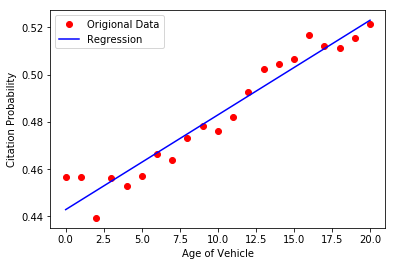

In [15]:
df = df_copy.groupby(['V_Age', 'Violation Type']).count()
ct_prob = list()

n = 20
ages = np.linspace(0,n, n+1)

for age in ages:
    citn = df.loc[(age, 'Citation'), 'Agency']
    other = df.loc[(age, 'Warning'), 'Agency']
    prob = citn/(citn + other)
    ct_prob.append(prob)

plt.plot(ages, ct_prob, 'ro', label = 'Origional Data')

slope, intercept, rvalue, pvalue, std_err = st.linregress(ages,ct_prob)
plt.plot(ages, intercept+slope*ages, 'b', label = 'Regression')

plt.xlabel('Age of Vehicle')
plt.ylabel('Citation Probability')
plt.legend()
print('Regression:', rvalue)
print('p-value:', pvalue)

<b>The difference in citation probability is not just a racial bias but due to the age of the vehicle they drive. Among different races, the asian drivers drive newest vehicle (average age of 7.3 yrs) compared to hispanic drivers (average vehicle age 10.5 yrs). The citation probability scales well with the age of the vehicle. </b>

To check the wheter or not this statement is statistically significant, we set a null hypothesis that Hispanic/Black drivers with new vehicle (age less than 1) have equal citation probability as compared to White/Asian drivers. We otbain a p-value in the order of $10^{-55}$, which means we can reject the null hypothesis. 

This means that the difference in citation probability among different races is not just the age of the vehicle they drive but there are other factors to be considered. 

In [16]:
df_new = df_copy[df_copy.V_Age <= 0]
hisblk = df_new[(df_new.Race == 'HISPANIC') | (df_new.Race == 'BLACK')]\
                   ['Violation Type']
hisblk = pd.get_dummies(hisblk, drop_first = True)

asnwht = df_new[(df_new.Race == 'ASIAN') | (df_new.Race == 'WHITE')]\
                   ['Violation Type']
asnwht = pd.get_dummies(asnwht, drop_first = True)

data1 = hisblk.Warning
data2 = asnwht.Warning

t_value, p_value = st.ttest_ind_from_stats(mean1 = data1.mean(), std1 = data1.std(), nobs1 = data1.count(),
                                           mean2 = data2.mean(), std2 = data2.std(), nobs2 = data2.count())

print('Hispanic/Black citation probability:', (data1.count() - data1.sum())/data1.count())
print('Asian/White citation probability:', (data2.count() -data2.sum())/data2.count())

print('p-value: ', p_value)

Hispanic/Black citation probability: 0.5001930129318665
Asian/White citation probability: 0.42743159615459464
p-value:  2.9935176572032782e-55
